In [106]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import itertools
import warnings
import gffutils
from tqdm import tqdm
import json

warnings.filterwarnings('ignore')
%matplotlib inline

In [209]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]


def load_database(db_file, gtf_file):
    if osp.isfile(db_file):
        db = gffutils.FeatureDB(db_file)
    else:
        db = gffutils.create_db(gtf_file, db_file)
    
    return db


def parse_query(line):
    start, end, chrom, table, featuretype = line
    select_from = 'SELECT * FROM {} WHERE'.format(table)
    start_req = 'start >= {}'.format(start)
    end_req = 'end <= {}'.format(end)
    len_req = 'end - start >= 1000'
    chrom_req = 'seqid = \"chr{}\"'.format(chrom)
    feature_req = 'featuretype = \"{}\"'.format(featuretype)
    where_reqs = ' AND '.join([start_req, end_req, len_req, chrom_req, feature_req])
    query = ' '.join([select_from, where_reqs])
    
    return query


def generate_query(regions, chrom, table='features', featuretype='gene'):
    regions['chrom'] = chrom
    regions['table'] = table
    regions['featuretype'] = featuretype
    reqs = regions.apply(parse_query, 1)

    return reqs


def merge_attr(attrs):
    if not attrs:
        raise ValueError(
            'No attributes detected. Please consider expanding your search by changing the filters'
        )
    return {k: [attr[k][0] if k in attr else None for attr in attrs] for k in attrs[0].keys()}


def check_attr(attr, filters):
    for restr in filters:
        if '=' not in restr:
            raise ValueError(
                'Cannot parse filter {}. Please doublecheck the input'.format(restr)
            )
        k, v = restr.strip().split('=')
        k, v = k.strip(), v.strip()
        if k not in attr:
            raise ValueError(
                'Cannot find key {} in attributes. Please doublecheck the input'.format(k)
            )
        if attr[k][0] != v: return False
    
    return True


def db_query(db, queries, filters=[]):
    chrom, start, end, attrs = [], [], [], []
    valid = 0
    for query in tqdm(queries, desc='querying database', position=0, leave=True):
        itr = db.execute(query).fetchall()
        for obj in itr:
            attr = json.loads(obj['attributes'])
            if filters:
                if not check_attr(attr, filters): continue
            chrom.append(obj['seqid'])
            start.append(obj['start'])
            end.append(obj['end'])
            attrs.append(attr)
            valid += 1
    if valid:
        info = pd.DataFrame({'chrom': chrom, 'start': start, 'end': end})
        attrs = pd.DataFrame(merge_attr(attrs))
        res = pd.concat([info, attrs], axis=1)
        print('Databse query completed with {} match(es)'.format(valid))
    else:
        res = None
        warnings.warn(
            'No match found. Please consider expanding your search by changing the filters',
            RuntimeWarning
        )

    return res, valid


def parse_res(row):
    start = int(max(row['start']//1e4 - 400, 0))
    locstart, locend = row['start']/1e4 - start, row['end']/1e4 - start
    gene = row['gene_name']

    return start, locstart, locend, gene

In [227]:
def topdom(pred_mat, window_size=10, cutoff=None):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = cutoff

    return signal


def interpolate(signal, bin_size=10000, pattern='smooth'):
    if pattern is None: return signal
    if pattern not in ['smooth', 'zigzag']:
        raise ValueError(
            'Bad parameter, expecting \'smooth\' or \'zigzag\' but got \'{}\''.format(pattern)
        )
    if pattern=='smooth':
        l = len(signal) * bin_size
        sparse, compact = np.linspace(0, l, len(signal)), np.linspace(0, l, l)
        interp_signal = np.interp(compact, sparse, signal)
    else:
        interp_signal = np.tile(signal, (bin_size, 1)).flatten('F')
    
    return interp_signal


def sim_pearson(signal1, signal2, window_size=10):
    l = len(signal1)
    score = np.array([
        scipy.stats.pearsonr(
            signal1[i:i+window_size], signal2[i:i+window_size]
        )[0] for i in range(l-window_size)
    ])
    score[score != score] = 1

    return score


def sim_difference(signal1, signal2):
    score = signal1 - signal2
    score[score != score] = 1

    return score


def similarity(signal1, signal2, kernel='diff', window_size=10):
    if len(signal1)-len(signal2):
        raise ValueError(
            'Different signal1.length ({}) and signal2.length ({})'.format(len(signal1), len(signal2))
        )
    if kernel == 'diff':
        score = sim_difference(signal1, signal2)
    elif kernel == 'pearson':
        score = sim_pearson(signal1, signal2, window_size=window_size)
    
    return score


def threshold(score, cutoff=0.7, kernel='diff', margin=1000):
    if kernel == 'diff':
        indices = np.argwhere(np.abs(score)>=cutoff).flatten()
    elif kernel == 'pearson':
        indices = np.argwhere(score <= cutoff).flatten()
    if len(indices) == 0:
        raise ValueError(
            'No valid result above threshold. Please consider expanding your search by changing the filters'
        )
    starts, ends = [], []
    s, e = 0, 0
    for i in tqdm(indices, desc='selecting significant regions', position=0, leave=True):
        if not s and not e: s, e = i, i
        else:
            if i - e <= margin: e = i
            else:
                starts.append(s)
                ends.append(e)
                s, e = i, i
    if e != ends[-1]:
        starts.append(s)
        ends.append(e)
    regions = pd.DataFrame({
        'start': np.array(starts) - margin,
        'end': np.array(ends) + margin
    })
    return regions

In [211]:
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
gtf_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.gtf'
db_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.db'
ct1 = 'mycGCB_am_gfp_myc_gcb_thelp_sample'
ct2 = 'mycGCB_am_gfp_myc_gcb_nothelp_sample'
chrom = 1
osp.join(pred_dir, ct1), osp.join(pred_dir, ct2)

('/data/leslie/suny4/predictions/chromafold/mycGCB_am_gfp_myc_gcb_thelp_sample',
 '/data/leslie/suny4/predictions/chromafold/mycGCB_am_gfp_myc_gcb_nothelp_sample')

In [212]:
%%time

pred1, pred2 = load_pred(pred_dir, ct1, chrom), load_pred(pred_dir, ct2, chrom)

CPU times: user 3.89 s, sys: 5.28 s, total: 9.17 s
Wall time: 9.32 s


In [213]:
%%time

signal1, signal2 = topdom(pred1, window_size=50, cutoff=0), topdom(pred2, window_size=50, cutoff=0)

CPU times: user 4.68 s, sys: 1.28 s, total: 5.96 s
Wall time: 5.96 s


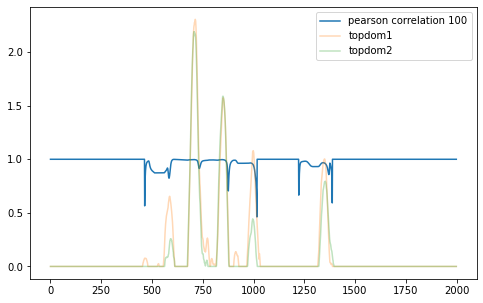

In [214]:
plt.figure(figsize=(8,5))
plt.plot(similarity(signal1, signal2, kernel='pearson', window_size=100)[3000:5000], 
         label='pearson correlation 100')
plt.plot(signal1[3000:5000], label='topdom1', alpha=0.3)
plt.plot(signal2[3000:5000], label='topdom2', alpha=0.3)
plt.legend()
plt.show()

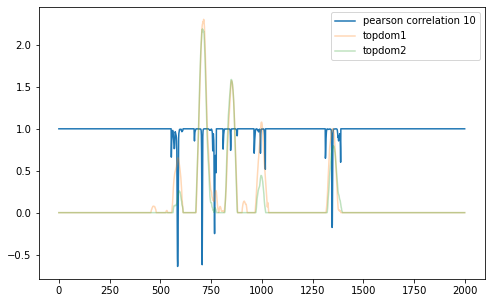

In [215]:
plt.figure(figsize=(8,5))
plt.plot(similarity(signal1, signal2, kernel='pearson', window_size=10)[3000:5000], 
         label='pearson correlation 10')
plt.plot(signal1[3000:5000], label='topdom1', alpha=0.3)
plt.plot(signal2[3000:5000], label='topdom2', alpha=0.3)
plt.legend()
plt.show()

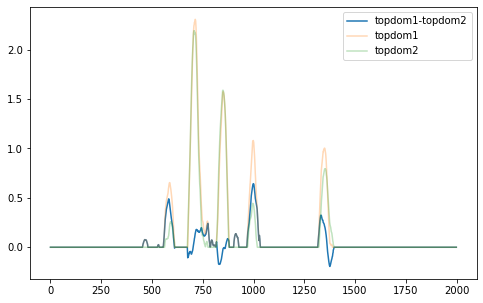

In [216]:
plt.figure(figsize=(8,5))
plt.plot(similarity(signal1, signal2, kernel='diff')[3000:5000], 
         label='topdom1-topdom2')
plt.plot(signal1[3000:5000], label='topdom1', alpha=0.3)
plt.plot(signal2[3000:5000], label='topdom2', alpha=0.3)
plt.legend()
plt.show()

In [217]:
%%time

raw_simscore = similarity(signal1, signal2, kernel='diff')
simscore = interpolate(raw_simscore, pattern='smooth')

CPU times: user 1.64 s, sys: 703 ms, total: 2.35 s
Wall time: 2.35 s


In [228]:
%%time

regions = threshold(simscore, cutoff=0.1, kernel='diff')
queries = generate_query(regions, chrom=chrom, table='features', featuretype='gene')

selecting significant regions: 100%|██████████| 20489364/20489364 [00:08<00:00, 2316586.03it/s]

CPU times: user 9.44 s, sys: 595 ms, total: 10 s
Wall time: 9.98 s


In [229]:
db = load_database(db_file, gtf_file)
print(db.schema())

CREATE TABLE features (
    id text,
    seqid text,
    source text,
    featuretype text,
    start int,
    end int,
    score text,
    strand text,
    frame text,
    attributes text,
    extra text,
    bin int,
    primary key (id)
    )
CREATE TABLE relations (
    parent text,
    child text,
    level int,
    primary key (parent, child, level)
    )
CREATE TABLE meta (
    dialect text,
    version text
    )
CREATE TABLE directives (
    directive text
    )
CREATE TABLE autoincrements (
    base text,
    n int,
    primary key (base)
    )
CREATE TABLE duplicates (
    idspecid text,
    newid text,
    primary key (newid)
    )
CREATE INDEX relationsparent ON relations (parent)
CREATE INDEX relationschild ON relations (child)
CREATE INDEX featuretype ON features (featuretype)
CREATE INDEX seqidstartend ON features (seqid, start, end)
CREATE INDEX seqidstartendstrand ON features (seqid, start, end, strand)
CREATE TABLE sqlite_stat1(tbl,idx,stat)


In [230]:
res, valid = db_query(db, queries, filters=['gene_type=protein_coding'])

querying database: 100%|██████████| 72/72 [00:00<00:00, 99.56it/s] 

Databse query completed with 124 match(es)


In [231]:
res

,chrom,start,end,gene_id,gene_type,gene_status,gene_name,level,havana_gene
0,chr1,13564698,13589910,ENSMUSG00000025935.10,protein_coding,KNOWN,Tram1,2,OTTMUSG00000049113.1
1,chr1,14168954,14310235,ENSMUSG00000025932.14,protein_coding,KNOWN,Eya1,1,OTTMUSG00000049176.2
2,chr1,37214434,37263384,ENSMUSG00000026114.14,protein_coding,KNOWN,Cnga3,1,OTTMUSG00000024612.5
3,chr1,37299865,37410736,ENSMUSG00000026113.17,protein_coding,KNOWN,Inpp4a,2,OTTMUSG00000033181.6
4,chr1,37417084,37430103,ENSMUSG00000026112.7,protein_coding,KNOWN,Coa5,2,OTTMUSG00000022117.2
...,...,...,...,...,...,...,...,...,...
119,chr1,181509633,181511451,ENSMUSG00000050625.4,protein_coding,KNOWN,Ccdc121,2,OTTMUSG00000044368.1
120,chr1,181896384,182019990,ENSMUSG00000022995.16,protein_coding,KNOWN,Enah,2,OTTMUSG00000050713.2
121,chr1,184013302,184075636,ENSMUSG00000039384.8,protein_coding,KNOWN,Dusp10,2,OTTMUSG00000033984.3
122,chr1,184033030,184034301,ENSMUSG00000044854.7,protein_coding,KNOWN,1700056E22Rik,2,OTTMUSG00000045249.1


In [232]:
start, locstart, locend, gene = parse_res(res.iloc[0])

In [233]:
start, locstart, locend, gene

(956, 400.4698000000001, 402.991, 'Tram1')

In [299]:
def rotate_coord(n):
    tmp = np.array(list(itertools.product(range(n,-1,-1),range(0,n+1,1))))
    tmp[:, [0, 1]] = tmp[:, [1, 0]]
    A = tmp.dot(np.array([[1, 0.5], [-1, 0.5]]))
    
    return A

def gaussian(n, sigma):
    kernel = np.array([1 / (n*np.sqrt(2*np.pi)) * np.exp(-i**2/(2*sigma**2)) for i in range(-n//2, n//2)])
    kernel /= kernel.sum()
    
    return kernel    


def verify_score(pred1, pred2, start, locstart, locend, window_size=10, cutoff=None):
    if pred1.shape[0]-pred1.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred1.shape[0], pred1.shape[1])
        )
    if pred2.shape[0]-pred2.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred2.shape[0], pred2.shape[1])
        )
    mat1 = pred1[start:start+700, start:start+700]
    mat2 = pred2[start:start+700, start:start+700]
    diff = mat1 - mat2
    n = 700
    A = rotate_coord(n)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
    ax1.pcolormesh(A[:, 1].reshape(n+1, n+1), A[:, 0].reshape(n+1, n+1),
                     np.flipud(mat1), cmap='RdBu_r', vmax=4, vmin=-1)
    ax1.set_xlim(300, 500)
    ax1.set_ylim(0, 200)
    ax2.pcolormesh(A[:, 1].reshape(n+1, n+1), A[:, 0].reshape(n+1, n+1),
                     np.flipud(mat2), cmap='RdBu_r', vmax=4, vmin=-1)
    ax2.set_xlim(300, 500)
    ax2.set_ylim(0, 200)
    ax3.pcolormesh(A[:, 1].reshape(n+1, n+1), A[:, 0].reshape(n+1, n+1),
                     np.flipud(diff), cmap='RdBu_r', vmax=2, vmin=-2)
    ax3.set_xlim(300, 500)
    ax3.set_ylim(0, 200)
    plt.show()
    
    score1, score2 = [], []
    for i in range(300, 500):
        val1 = np.nanmean(mat1[i-window_size:i, i:i+window_size])
        val2 = np.nanmean(mat2[i-window_size:i, i:i+window_size])
        if cutoff is not None:
            val1 = cutoff if val1 < cutoff else val1
            val2 = cutoff if val2 < cutoff else val2
        score1.append(val1)
        score2.append(val2)
    score = np.abs(np.array(score1) - np.array(score2))
    normal = gaussian(len(score), window_size)
    normalscore = score.dot(normal)
    
    return normalscore

Il1r2 3607 400.40790000000015 405.5230999999999


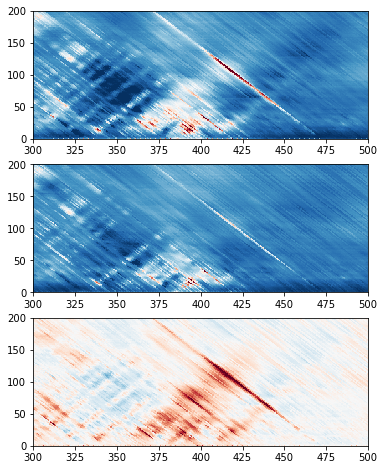

score: 0.19563415739690193
Nck2 3944 400.45790000000034 413.0514999999996


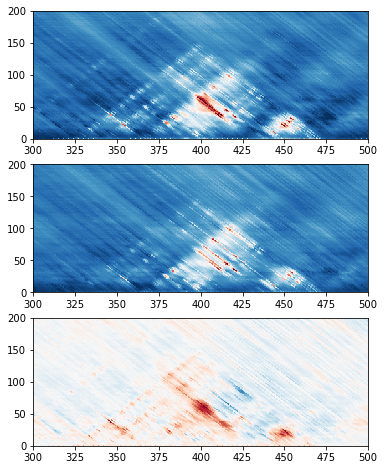

score: 0.1022807408503367
1500015O10Rik 3973 400.0601999999999 401.2578000000003


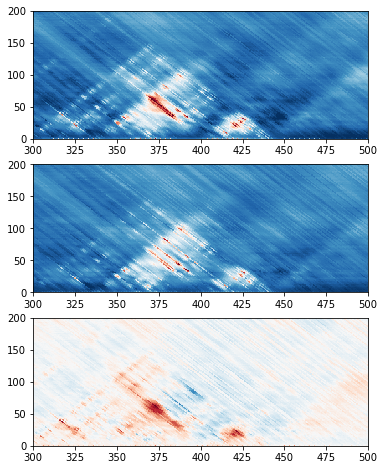

score: 0.09376372934675804
Uxs1 3974 400.6966000000002 408.77999999999975


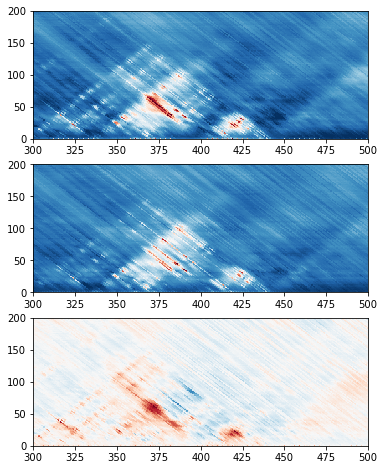

score: 0.09301247280701651
Nab1 4845 400.72940000000017 405.0679


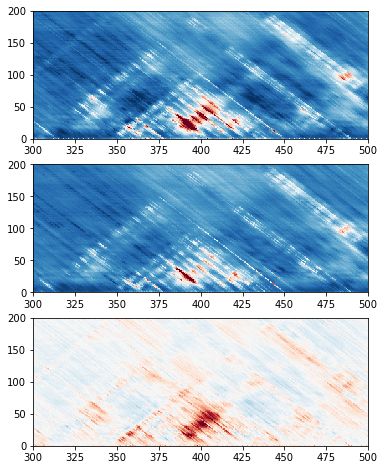

score: 0.14506787920872757
Tmem194b 4863 400.0703000000003 402.1918999999998


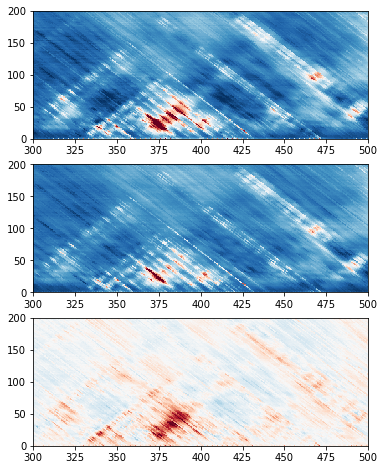

score: 0.14211651008605297
Ormdl1 4929 400.70949999999993 402.03089999999975


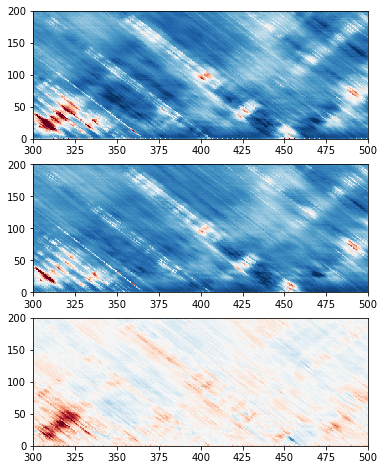

score: 0.072295192971671
Gm28778 4929 400.71110000000044 402.8035


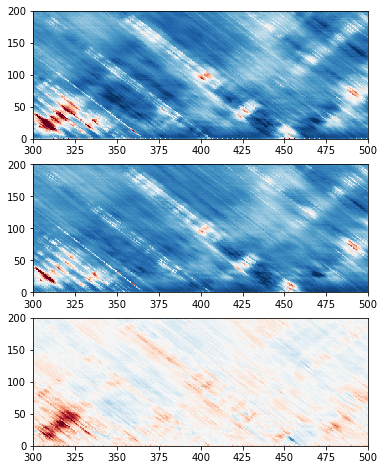

score: 0.072295192971671
Osgepl1 4931 400.3624 401.6342999999997


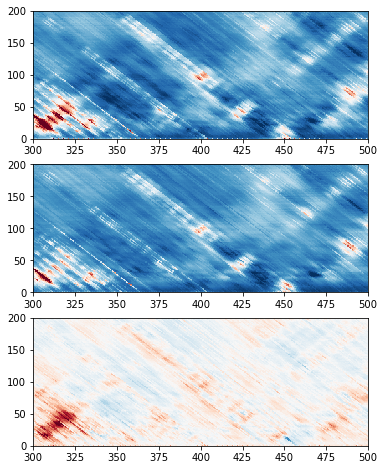

score: 0.07024692145323312
Casp8 5479 400.53740000000016 405.7502999999997


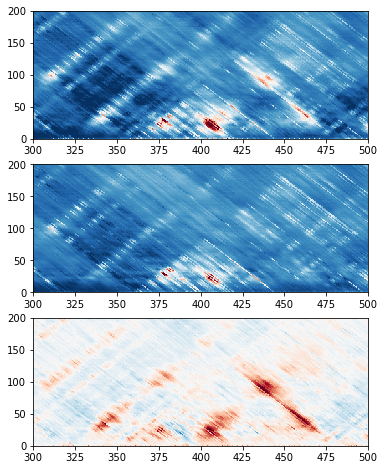

score: 0.08821748976306282


In [300]:
for i in range(10, 20):
    start, locstart, locend, gene = parse_res(res.iloc[i])
    print(gene, start, locstart, locend)
    score = verify_score(pred1, pred2, start, locstart, locend, window_size=50, cutoff=0)
    print('score: {}'.format(score))